## Análisis exploratorio de datos (EDA)

In [1]:
import os
import pandas as pd

In [2]:
# Cambiar directorio
os.chdir("..")

In [3]:
# Cargar los datos que tenemos disponibles
data = pd.read_csv("data/churn.csv")


In [4]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Nos deshacemos de las columnas que no contribuyen en mucho
data = data.drop(data.columns[0:3], axis=1)

In [6]:
# Convertimos los datos en formato categorico, para más info: shorturl.at/y0269
column_equivalence = {}
features = list(data.columns)
# Iteramos sobre los tipos de datos de cada columna, convirtiéndolos a string para poder compararlos
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    # Si la columna es de tipo 'object' (categoría o texto)
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())     # Rellenamos valores nulos con el valor más frecuente (moda)
        categorical_column = data[data.columns[i]].astype("category")                          # Convertimos la columna a tipo 'category' (categoría de pandas)
        current_column_equivalence = dict(enumerate(categorical_column.cat.categories))        # Diccionario que asocia índices numéricos a cada categoría
        column_equivalence[i] = dict((v,k) for k,v in current_column_equivalence.items())      # Invertimos el diccionario
        data[data.columns[i]] = categorical_column.cat.codes                                   # Reemplazamos las categorías por sus códigos numéricos en la columna
    # Si la columna no es de tipo 'object' (numérica u otro)
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())   # Rellenamos valores nulos con la mediana de la columna

In [7]:
column_equivalence

{1: {'France': 0, 'Germany': 1, 'Spain': 2}, 2: {'Female': 0, 'Male': 1}}

## Entrenamiento del modelo

In [8]:
# Vamos a crear un modelo de regresion logistica
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [9]:
# Generar los datos para poder separar la variable de respuesta de los datos que tenemos disponibles
X = data.copy()
y = X.pop(data.columns[-1])

In [10]:
# Separar los datos en datos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [11]:
# Crear el modelo y entrenarlo
clf_lin =  LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)

## Evaluación del modelo

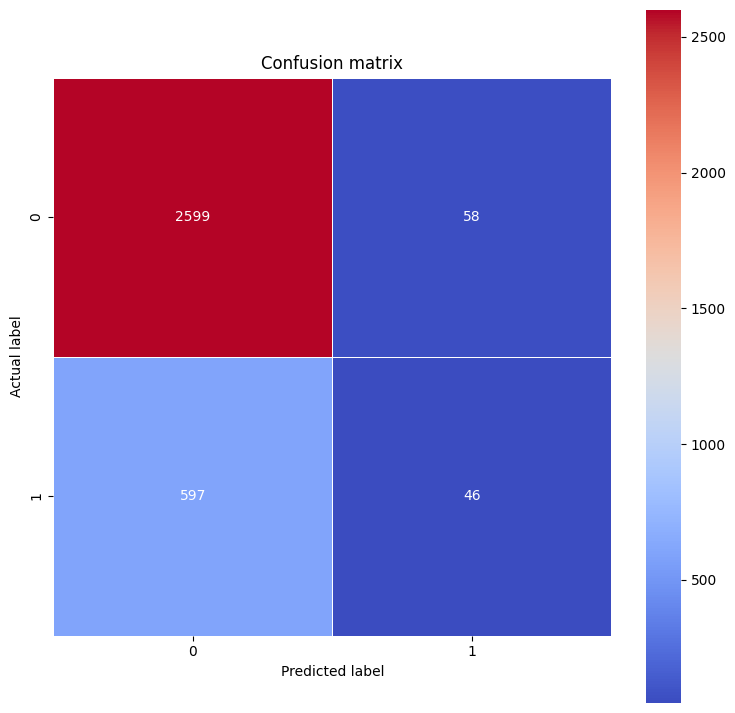

In [12]:
# Medir los resultados obtenidos usando una matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, clf_lin.predict(X_test))

#Visualizar la matriz de confusión
plt.figure(figsize=(9,9))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, fmt='g', linewidths=.5, square=True, cmap='coolwarm')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
# Metricas de éxito propuestas para evaluar el modelo, en todas se busca un valor cercano a 1
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Predecir resultados con los datos de prueba
prediction_test = clf_lin.predict(X_test)

# Exactitud: proporción de predicciones correctas.
print(f"Accuracy model: {accuracy_score(y_test, prediction_test):.3f}")

# Sensibilidad: capacidad del modelo de identificar todas las muestras positivas para un label.
print(f"Exited Churn='NO': {recall_score(y_test, prediction_test, pos_label=0):.3f}")
print(f"Exited Churn='YES': {recall_score(y_test, prediction_test, pos_label=1):.3f}")

# F1 Score: media armónica entre precisión y sensibilidad, nos da una mejor idea de que tan bien se comporta el modelo de forma global.
print(f"F1 Score: {f1_score(y_test, prediction_test):.3f}")
# En ocasiones, esta última metrica se usa en competiciones (Kaggle, DataDriven) para comparar modelos.


Accuracy model: 0.802
Exited Churn='NO': 0.978
Exited Churn='YES': 0.072
F1 Score: 0.123


## Exportación con pickle

In [14]:
# Generar el binario del modelo para reutilizarlo, equivalencia de variables categoricas y caracteristicas del modelo
import pickle
#Tener en cuenta esta nota de la documentación de Python
#"Warning: The pickle module is not secure. Only unpickle data you trust."

pickle.dump(clf_lin, open("churn/models/model.pk", "wb"))
pickle.dump(column_equivalence, open("churn/models/column_equivalence.pk", "wb"))
pickle.dump(features, open("churn/models/features.pk", "wb"))